In [17]:
""" from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import erdos_renyi_graph
import random
import torch


def generate():
    edge_index = erdos_renyi_graph(13, 0.5)
    has_lt_3_or_gt_10_neighbors = (edge_index[0].bincount() < 4) | (edge_index[0].bincount() > 9)
    return Data(x=torch.ones((13, 1)), edge_index=edge_index, y=int(has_lt_3_or_gt_10_neighbors.max()))

datalist = [
    generate() for _ in range(10000)
]
random.shuffle(datalist)
iteration = 1
train_data = datalist[:iteration * 1250] + datalist[(iteration + 1) * 1250:]
val_data = datalist[iteration * 1250 : (iteration + 1) * 1250]

train_loader = DataLoader(train_data, batch_size=8750, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1250, shuffle=False) """

' from torch_geometric.data import Data\nfrom torch_geometric.loader import DataLoader\nfrom torch_geometric.utils import erdos_renyi_graph\nimport random\nimport torch\n\n\ndef generate():\n    edge_index = erdos_renyi_graph(13, 0.5)\n    has_lt_3_or_gt_10_neighbors = (edge_index[0].bincount() < 4) | (edge_index[0].bincount() > 9)\n    return Data(x=torch.ones((13, 1)), edge_index=edge_index, y=int(has_lt_3_or_gt_10_neighbors.max()))\n\ndatalist = [\n    generate() for _ in range(10000)\n]\nrandom.shuffle(datalist)\niteration = 1\ntrain_data = datalist[:iteration * 1250] + datalist[(iteration + 1) * 1250:]\nval_data = datalist[iteration * 1250 : (iteration + 1) * 1250]\n\ntrain_loader = DataLoader(train_data, batch_size=8750, shuffle=True)\nval_loader = DataLoader(val_data, batch_size=1250, shuffle=False) '

In [18]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
import torch

torch.manual_seed(42)

dataset = TUDataset(root='data', name='NCI1')
n_val = len(dataset) // 8; iteration = 1
permutation = torch.randperm(len(dataset))

val_data = dataset[permutation[iteration * n_val : (iteration + 1) * n_val]]
train_data = dataset[torch.concat([permutation[:iteration * n_val], permutation[(iteration + 1) * n_val:]])]

val_loader = DataLoader(val_data, batch_size=n_val, shuffle=False)
train_loader = DataLoader(train_data, batch_size=len(train_data), shuffle=True)

num_classes = train_data.y.max().item() + 1
bincount = torch.bincount(train_data.y, minlength=num_classes)
weight = (len(train_data) / (num_classes * bincount.float()))

train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))
sample_weight = weight[train_batch.y]

In [19]:
from gnnexplain.nn.gnn import GNN
from lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
import wandb

torch.set_float32_matmul_precision('high')

model = GNN(dataset.num_features, dataset.num_classes, layers=8, dim=128, activation="ReLU", conv="GIN", aggr="mean", lr=1e-4, weight=weight)
logger = WandbLogger(project="gnnexplain", group=f'test')

trainer = Trainer(
    max_steps=100,
    logger=logger,
    devices=[2],
    enable_checkpointing=False,
    enable_progress_bar=True,
    log_every_n_steps=1
)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
wandb.finish()	

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name        | Type       | Params
-------------------------------------------
0 | embedding   | Linear     | 4.9 K 
1 | act         | ReLU       | 0     
2 | norms       | ModuleList | 3.1 K 
3 | conv_layers | ModuleList | 132 K 
4 | out         | Sequential | 16.8 K
5 | loss        | NLLLoss    | 0     
-------------------------------------------
156 K     Trainable params
0         Non-trainable params
156 K     Total params
0.627     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/apluska/miniconda3/envs/gnnexplain/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


/home/apluska/miniconda3/envs/gnnexplain/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, v_num=87tf]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s, v_num=87tf]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▂▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████
train_f1_macro,▁▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
train_f1_micro,▁▂▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████
train_loss,█▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██
val_f1_macro,▁▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██
val_f1_micro,▁▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██
val_loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99


In [20]:
import numpy as np

labels = []
for graph, y in zip(train_batch.to_data_list(), train_batch.y):
    labels.append(y * np.ones(graph.num_nodes))
labels = np.concatenate(labels, axis=0)
labels.shape

(107345,)

In [21]:
from gnnexplain.model.gtree import _get_values

values = _get_values(train_batch, model)
values[0].shape

(107345, 128)

In [33]:
from gnnexplain.model.gtree import Explainer

explainer = Explainer(width=8, sample_size=500, layer_depth=2, max_depth=None, ccp_alpha=1e-3)

In [34]:
from cProfile import Profile
from pstats import Stats

profiler = Profile()
profiler.runcall(explainer.fit, train_batch, values, train_batch.y)  #model(train_batch).argmax(-1).detach().numpy()
stats = Stats(profiler)
stats.strip_dirs().sort_stats('cumulative').print_stats(30)

         5628867 function calls (5563603 primitive calls) in 106.438 seconds

   Ordered by: cumulative time
   List reduced from 595 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       25    0.002    0.000   99.234    3.969 base_events.py:1908(_run_once)
       64    2.834    0.044   71.494    1.117 gtree.py:192(fit)
      129    0.002    0.000   69.451    0.538 base.py:1134(wrapper)
       65    0.006    0.000   61.166    0.941 _classes.py:221(_fit)
       65   60.777    0.935   60.777    0.935 {method 'build' of 'sklearn.tree._tree.DepthFirstTreeBuilder' objects}
       64    0.007    0.000   59.643    0.932 _classes.py:1290(fit)
        1    0.522    0.522   29.844   29.844 gtree.py:90(fit)
       64   19.503    0.305   25.294    0.395 gtree.py:223(predict)
      384    0.001    0.000    4.105    0.011 _base.py:620(__matmul__)
      384    0.004    0.000    4.097    0.011 _base.py:505(_mul_dispatch)
      128    0.001    0.0

In [24]:
explainer.accuracy(train_batch)

0.7080900750625522

In [25]:
explainer.accuracy(val_batch)

0.6764132553606238

In [26]:
explainer.f1_score(val_batch)

0.6763825129966863

In [27]:
explainer.fidelity(val_batch, model)

0.6842105263157895

In [28]:
explainer.prune()

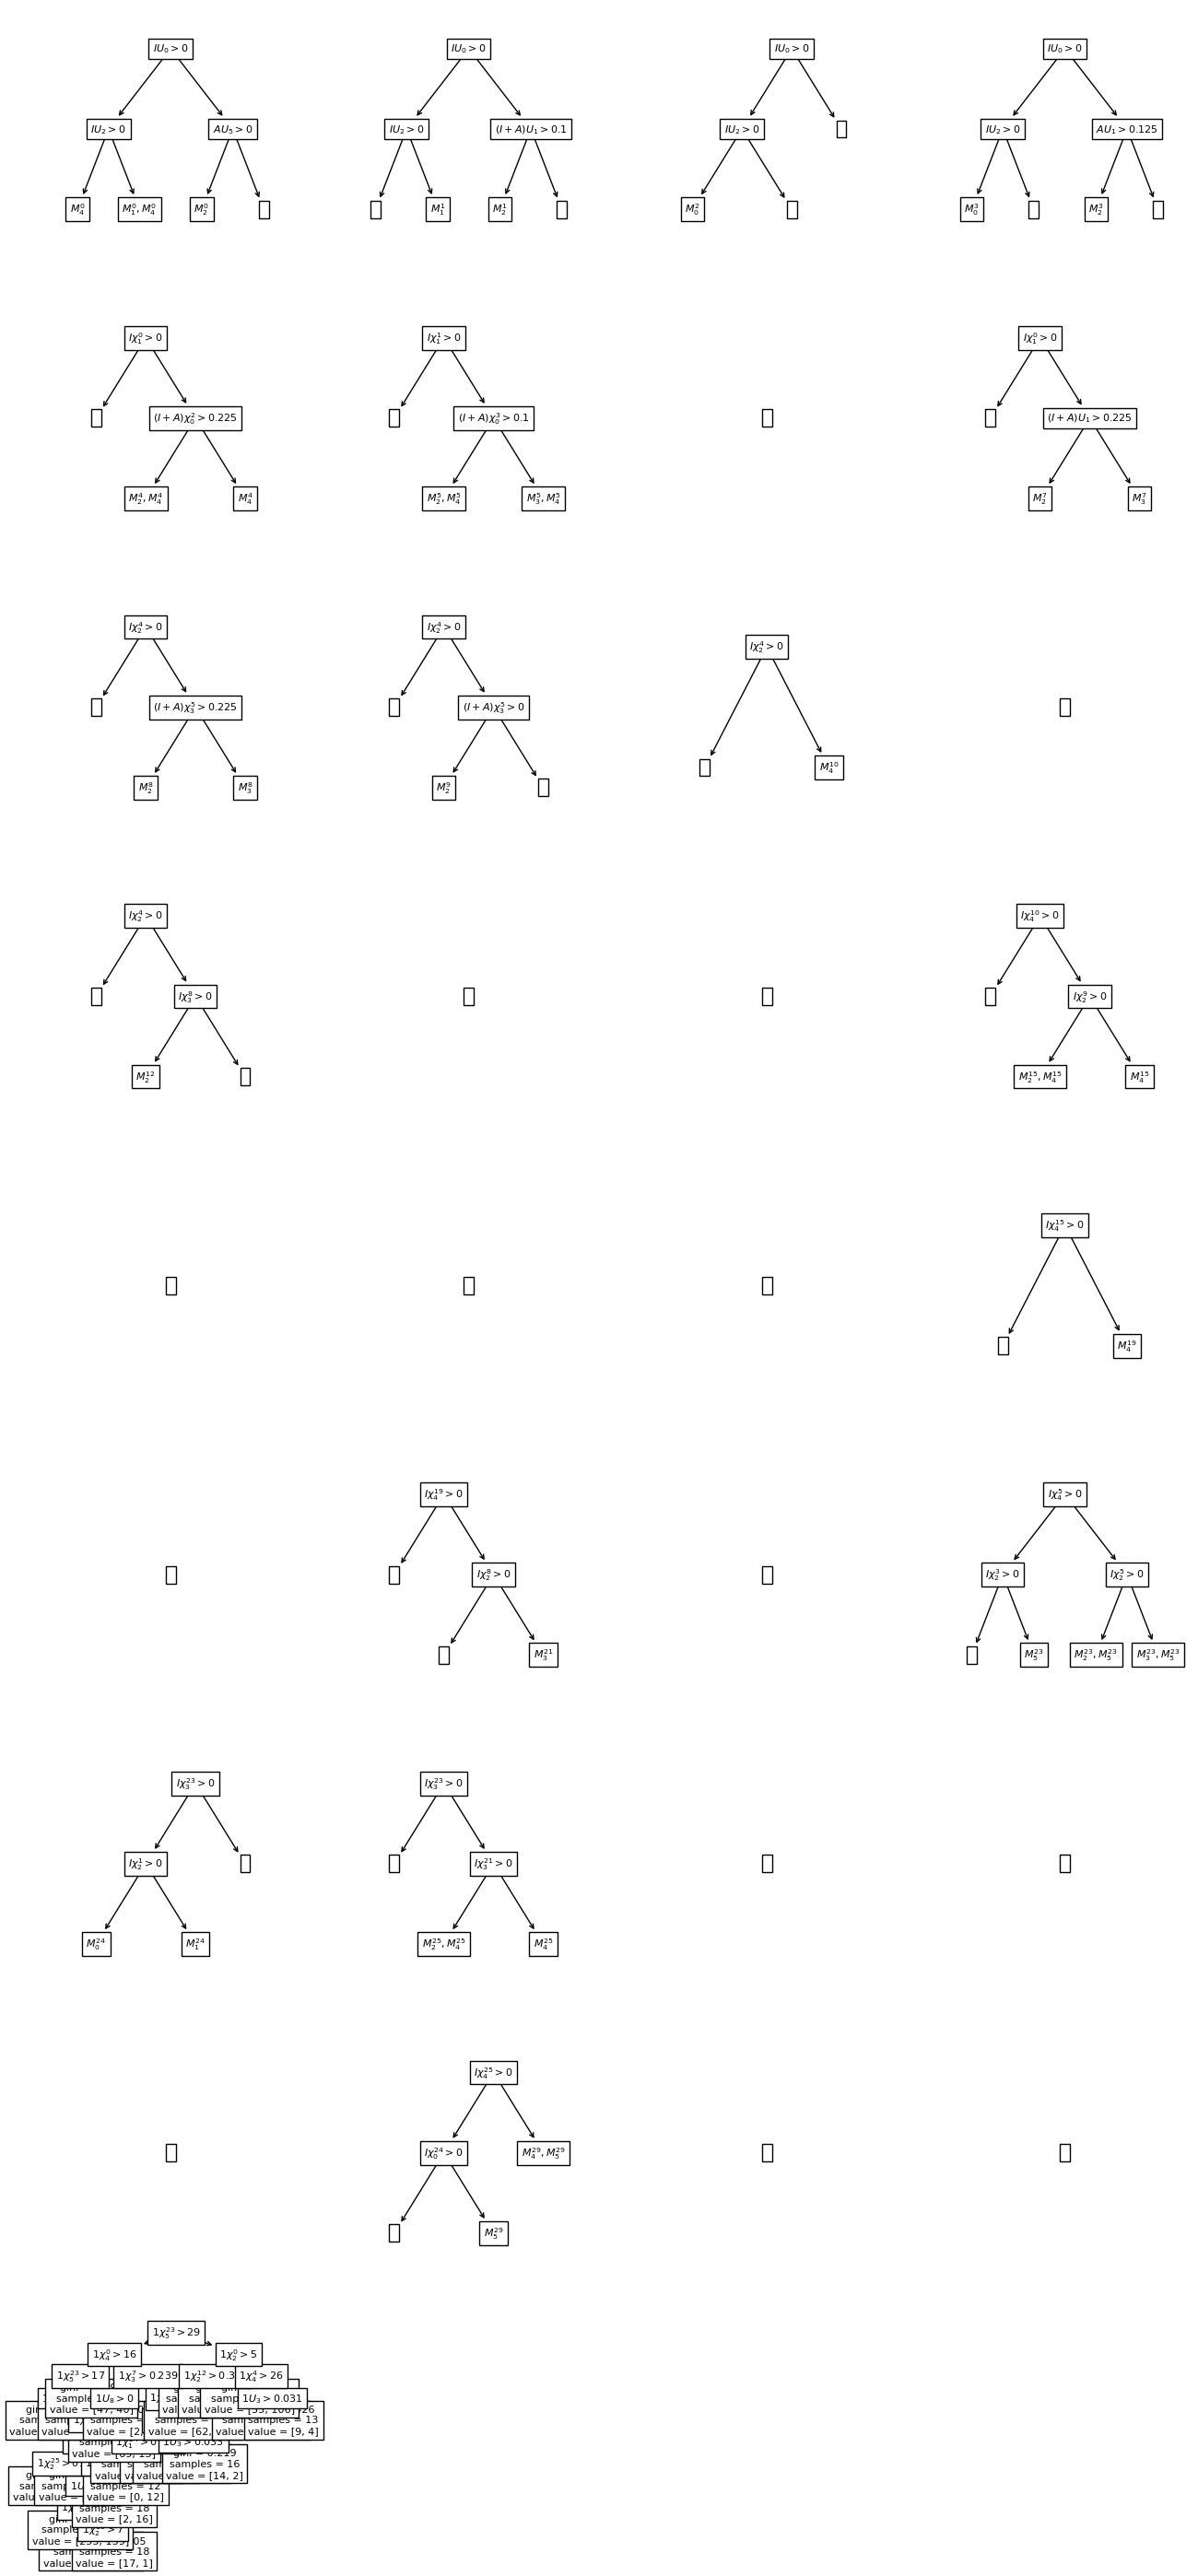

In [29]:
explainer.plot()

In [30]:
explainer.save_image('./test.png')

In [67]:
from torch_geometric.data import Data
from torch_geometric.utils import erdos_renyi_graph
import torch

def generate():
    edge_index = erdos_renyi_graph(13, 0.5)
    u0 = (torch.randn((13, 1)) == 0).float()
    u1 = torch.ones((13, 1), dtype=torch.float)
    u = torch.cat([u0, u1], dim=1)
    has_at_least_7_neighbors = edge_index[0].bincount() > 6
    has_at_last_half_neighbours_with_6_neighbors = has_at_least_7_neighbors[edge_index[1]]
    return Data(x=u, edge_index=edge_index, y=(has_at_last_half_neighbours_with_6_neighbors.float().mean() > 0.5).long())

In [1]:
import torch
from joblib import Parallel, delayed

def job():
    torch.manual_seed(42)
    return torch.randperm(10)

Parallel(n_jobs=2)(delayed(job)() for _ in range(2))